<a href="https://colab.research.google.com/github/ThinkingBeyond/BeyondAI-2024/blob/main/Cancer_Dataset_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Necessary Libraries

In [1]:
!pip install git+https://github.com/KindXiaoming/pykan.git

  Cloning https://github.com/KindXiaoming/pykan.git to /tmp/pip-req-build-ceiowc7t
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-ceiowc7t
  Resolved https://github.com/KindXiaoming/pykan.git to commit f871c26d4df788ec1ba309c2c9c1803d82606b06
  Preparing metadata (setup.py) ... done
  Created wheel for pykan: filename=pykan-0.2.8-py3-none-any.whl size=78208 sha256=842f269238e81386e61b533a9d72fd377eba5f6d0610e25151362df2edc68b8a
  Stored in directory: /tmp/pip-ephem-wheel-cache-qndv4bzu/wheels/47/ca/5a/98124e020f3119f51c17f78738c621c140b7aa803b0feda76e
Successfully built pykan


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from kan import *
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, classification_report
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings("ignore")

##Models

The models are being called here along with the number of layers, activation function and other hyperparameters needed for the initial run

In [3]:
#MLP Model
mlp = MLPClassifier()#default parameters
#KAN Model
kan = KAN(width=[2,2,1])# should be adjusted based on dataset

checkpoint directory created: ./model
saving model version 0.0


#Functions

All the functions to be used for calculating the accuracies, losses, precision, recall, confusion matrix. The function to plot the graph is also written here.

##Model Functions

In [4]:
def MLP_run(mlp,X_train,y_train,X_test,y_test,epochs):
  y_train = torch.tensor(y_train, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)
  train_accuracies,test_accuracies = [],[]
  train_losses,test_losses = [],[]
  criterion = nn.MSELoss()
  start_time = time.time()

  for epoch in range(epochs):
    mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))
    y_pred_train = mlp.predict(X_train)
    train_acc = accuracy_score(y_train, torch.tensor(y_pred_train))
    train_loss = criterion(torch.tensor(y_pred_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    train_accuracies.append(train_acc)
    train_losses.append(train_loss.item())
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}],MLP Train Loss: {train_loss.item():.3f}, MLP Train Accuracy: {train_acc}')

  for epoch in range(epochs):
    y_pred_test = mlp.predict(X_test)
    test_acc = accuracy_score(torch.tensor(y_test), torch.tensor(y_pred_test))
    test_loss = criterion(torch.tensor(y_pred_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
    test_accuracies.append(test_acc)
    test_losses.append(test_loss.item())
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}],MLP Test Loss: {test_loss.item():.3f}, MLP Test Accuracy: {test_acc}')
  end_time = time.time()
  MLP_Execution_Time = end_time - start_time
  return train_accuracies,test_accuracies,train_losses,test_losses,MLP_Execution_Time


def KAN_run(model,X_train,y_train,X_test,y_test,epochs):
  y_train = torch.tensor(y_train, dtype=torch.long)
  y_test = torch.tensor(y_test, dtype=torch.long)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
  loss_fn = nn.CrossEntropyLoss()
  kan_train_accuracy = []
  kan_test_accuracy = []
  kan_train_loss = []
  kan_test_loss = []
  starting_time = time.time()

  for epoch in range(epochs): #training
    optimizer.zero_grad()
    outputs = model(X_train)
    predicted = torch.argmax(outputs, dim=1)
    train_accuracy = accuracy_score(y_train, predicted)
    train_loss = loss_fn(outputs, y_train)
    train_loss.backward()
    optimizer.step()
    kan_train_accuracy.append(train_accuracy)
    kan_train_loss.append(train_loss.item())
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}],KAN Train Loss: {train_loss.item():.3f}, KAN Train Accuracy: {train_accuracy}')

  for epoch in range(epochs): # testing
    predicted = model(x_test_tensor)
    test_accuracy = accuracy_score(y_test_tensor, predicted.argmax(1))
    test_loss = loss_fn(predicted, y_test_tensor)
    kan_test_accuracy.append(test_accuracy)
    kan_test_loss.append(test_loss.item())
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}],KAN Test Loss: {test_loss.item():.3f},KAN Test Accuracy: {test_accuracy:.3f}')
  final_time = time.time()
  KAN_Execution_Time = final_time - starting_time
  return kan_train_accuracy, kan_test_accuracy, kan_train_loss, kan_test_loss, KAN_Execution_Time

##Model Run Function

In [5]:
def run_models(epochs):
  mlp_model_run = MLP_run(mlp,x_train_tensor,y_train_tensor,x_test_tensor,y_test_tensor,epochs)
  mlp_metrics = [mlp_model_run[0],mlp_model_run[1],mlp_model_run[2],mlp_model_run[3]]
  print(f'MLP Execution time: {mlp_model_run[4]:.2f} seconds')

  print()

  kan_model_run = KAN_run(kan,x_train_tensor,y_train_tensor,x_test_tensor,y_test_tensor,epochs)
  kan_metrics = [kan_model_run[0],kan_model_run[1],kan_model_run[2],kan_model_run[3]]
  print(f'KAN Execution time: {kan_model_run[4]:.2f} seconds')
  return mlp_metrics,kan_metrics

##Plot Function

In [6]:
def plot_comparison_over_epochs(mlp_metrics,kan_metrics, num_epochs):
    epochs = range(1, num_epochs + 1)
    mlp_train_acc, mlp_test_acc, mlp_train_loss, mlp_test_loss = mlp_metrics
    kan_train_acc, kan_test_acc, kan_train_loss, kan_test_loss = kan_metrics
    plt.figure(figsize=(10,6))

    # Graph of Train Accuracy for both models over number of epochs
    plt.subplot(121)
    plt.plot(epochs, mlp_train_acc, label='MLP Train Accuracy',color='blue')
    plt.plot(epochs, kan_train_acc, label='KAN Train Accuracy',color='red')
    plt.plot(epochs, mlp_test_acc, label='MLP Test Accuracy',color='green')
    plt.plot(epochs, kan_test_acc, label='KAN Test Accuracy',color='yellow')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('MLP and KAN Train Accuracy Over Epochs')
    plt.legend()

    # Graph of loss of both models during training
    plt.subplot(122)
    plt.plot(epochs, mlp_train_loss, label='MLP Train Loss',color='blue')
    plt.plot(epochs, kan_train_loss, label='KAN Train Loss',color='red')
    plt.ylim(0, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

##Comparison Criteria Functions

In [7]:
def criteria_comparison(mlp,kan,x_test_tensor,y_test_tensor):
  mlp_classification= classification_report(y_test_tensor, mlp.predict(x_test_tensor))
  kan_classification = classification_report(y_test_tensor, kan(x_test_tensor).argmax(1))
  mlp_confusion = confusion_matrix(y_test_tensor, mlp.predict(x_test_tensor))
  kan_confusion = confusion_matrix(y_test_tensor, kan(x_test_tensor).argmax(1))
  print(f'MLP Classification Report:\n{mlp_classification}')
  print(f'MLP Confusion Matrix:\n{mlp_confusion}')
  print(f'KAN Classification Report:\n{kan_classification}')
  print(f'KAN Confusion Matrix:\n{kan_confusion}')

#Dataset

The dataset to be used for the analysis is loaded here as well as preparation for the dataset using standard scaler(to make every feature have a mean of 0 and a standard deviation of 1) for faster convergence and imporved performance

##Load Dataset

In [8]:
url_wisconsin_breast_cancer = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
df = pd.read_csv(url_wisconsin_breast_cancer, header=None)
df[10]=df[10].replace(2,0)
df[10]=df[10].replace(4,1)
x = df.drop([6, 10], axis=1).values
y = df[10].values

##Prepare Dataset

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)
# Converting data to tensors
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train)
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test)

# Runing the model
Running the models over 300 epochs with different hidden layers for MLP and KAN with that of KAN being lower than MLP at all points

Plotting the accuracies and loss over epochs

Calculating other comparison criteria




In [10]:
epochs = 200

### Model Run with same number of hidden layers
MLP:3(600,350,100) and KAN: 3(5,5,5)

In [ ]:
param_grid_mlp_0 = {'hidden_layer_sizes': [(600,350,100)],
    'activation': ['relu', 'tanh','logistics'],
    'alpha':[0.01,0.1],
    'solver':['adam','sgd'],
    'learning_rate':['adaptive','constant']}
mlp_0 = MLPClassifier(max_iter=1000, random_state=42)
clfmlp_0 = GridSearchCV(mlp_0, param_grid_mlp_0, cv=5, scoring='accuracy')
clfmlp_0.fit(X_train, y_train)
print(f"Best accuracy: {clfmlp_0.best_score_}")
print(f"Best parameters: {clfmlp_0.best_params_}")

Best accuracy: 0.9545897877223177
Best parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (600, 350, 100), 'learning_rate': 'adaptive', 'solver': 'sgd'}


In [ ]:
# kan hyperparameter tunning for kan_0
grids_0 = range(3,11,1)
ks_0 = range(2,9,1)
noises_0 = np.arange(0.1,0.9,0.1).tolist()
mult_arities_0 = [2,3,4,5]
accuracies_0=[]
hyperparameters_0 = []
for grid in grids_0:
  for k in ks_0:
    for noise in noises_0:
      for mult_arity in mult_arities_0:
        kan = KAN(width=[9,5,5,5,2], grid=grid, k=k,noise_scale=noise,mult_arity=mult_arity,seed=42)
        y_pred = kan(x_train_tensor).argmax(1)
        accuracy = accuracy_score(y_train_tensor, y_pred)
        accuracies_0.append(accuracy)
        hyperparameters_0.append((grid,k,noise,mult_arity))
print(max(accuracies_0))
index = accuracies_0.index(max(accuracies_0))
print(hyperparameters_0[index])

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model vers

checkpoint directory created: ./model
saving model version 0.0
Epoch [10/200],MLP Train Loss: 0.150, MLP Train Accuracy: 0.8496420047732697
Epoch [20/200],MLP Train Loss: 0.074, MLP Train Accuracy: 0.9260143198090692
Epoch [30/200],MLP Train Loss: 0.060, MLP Train Accuracy: 0.9403341288782816
Epoch [40/200],MLP Train Loss: 0.053, MLP Train Accuracy: 0.9474940334128878
Epoch [50/200],MLP Train Loss: 0.050, MLP Train Accuracy: 0.9498806682577565
Epoch [60/200],MLP Train Loss: 0.048, MLP Train Accuracy: 0.9522673031026253
Epoch [70/200],MLP Train Loss: 0.048, MLP Train Accuracy: 0.9522673031026253
Epoch [80/200],MLP Train Loss: 0.043, MLP Train Accuracy: 0.9570405727923628
Epoch [90/200],MLP Train Loss: 0.043, MLP Train Accuracy: 0.9570405727923628
Epoch [100/200],MLP Train Loss: 0.043, MLP Train Accuracy: 0.9570405727923628
Epoch [110/200],MLP Train Loss: 0.043, MLP Train Accuracy: 0.9570405727923628
Epoch [120/200],MLP Train Loss: 0.043, MLP Train Accuracy: 0.9570405727923628
Epoch [130

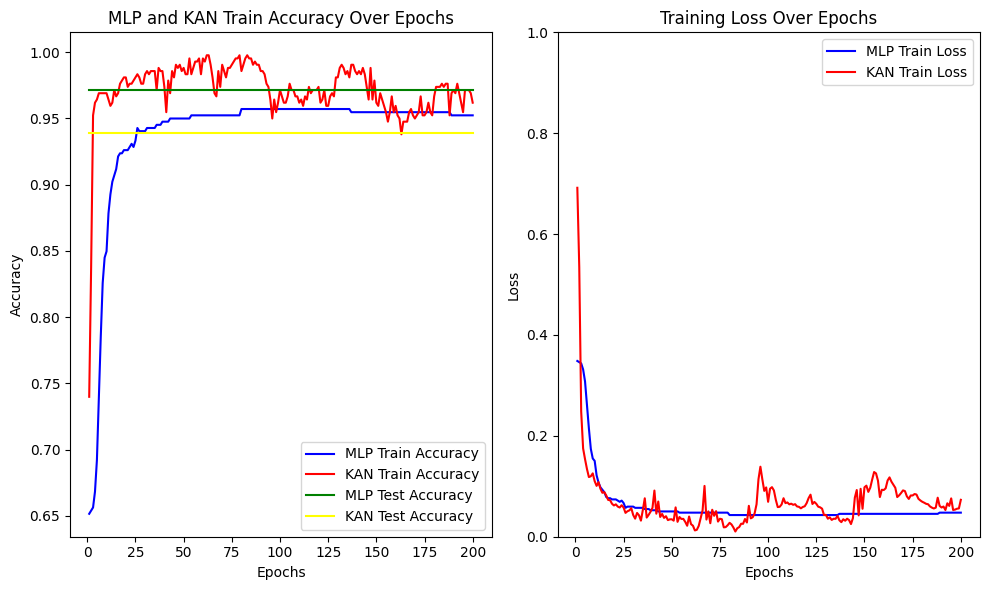

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       185
           1       0.95      0.97      0.96        95

    accuracy                           0.97       280
   macro avg       0.97      0.97      0.97       280
weighted avg       0.97      0.97      0.97       280

MLP Confusion Matrix:
[[180   5]
 [  3  92]]
KAN Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       185
           1       0.91      0.91      0.91        95

    accuracy                           0.94       280
   macro avg       0.93      0.93      0.93       280
weighted avg       0.94      0.94      0.94       280

KAN Confusion Matrix:
[[177   8]
 [  9  86]]


In [11]:
mlp = MLPClassifier(hidden_layer_sizes=(600,350,100),
                    max_iter=1000,
                    activation='relu',
                    learning_rate='adaptive',
                    alpha= 0.01,
                    solver='sgd',
                    random_state=42,
                    verbose = False)

kan = KAN(width= [9,5,5,5,2], grid=8, k=6,noise_scale = 0.2,mult_arity=4, seed=42)
mlp_metrics,kan_metrics = run_models(epochs)
plot_comparison_over_epochs(mlp_metrics, kan_metrics,epochs)
criteria_comparison(mlp,kan,x_test_tensor,y_test_tensor)

### Model Run with  hidden layers
MLP:2(64,32) and KAN: 1(19)

In [ ]:
# hyperparameter tunning for the hidden layers
param_grid_mlp_1 = {'hidden_layer_sizes': [(64,32)],
    'activation': ['relu', 'tanh','logistics'],
    'alpha':[0.01,0.1],
    'solver':['adam','sgd'],
    'learning_rate':['adaptive','constant']}
mlp_1 = MLPClassifier(max_iter=1000, random_state=42)
clfmlp_1 = GridSearchCV(mlp_1, param_grid_mlp_1, cv=5, scoring='accuracy')
clfmlp_1.fit(X_train, y_train)
print(f"Best accuracy: {clfmlp_1.best_score_}")
print(f"Best parameters: {clfmlp_1.best_params_}")

Best accuracy: 0.9569994262765347
Best parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (64, 32), 'learning_rate': 'adaptive', 'solver': 'sgd'}


In [ ]:
# kan hyperparameter tunning for kan_1
grids_1 = range(3,11,1)
ks_1 = range(2,9,1)
noises_1 = np.arange(0.1,0.9,0.1).tolist()
mult_arities_1 = [2,3,4,5]
accuracies_1=[]
hyperparameters_1 = []
for grid in grids_1:
  for k in ks_1:
    for noise in noises_1:
      for mult_arity in mult_arities_1:
        kan = KAN(width=[9,19,2], grid=grid, k=k,noise_scale=noise,mult_arity=mult_arity,seed=42)
        y_pred = kan(x_train_tensor).argmax(1)
        accuracy = accuracy_score(y_train_tensor, y_pred)
        accuracies_1.append(accuracy)
        hyperparameters_1.append((grid,k,noise,mult_arity))
print(max(accuracies_1))
index = accuracies_1.index(max(accuracies_1))
print(hyperparameters_1[index])

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model vers

checkpoint directory created: ./model
saving model version 0.0
Epoch [10/200],MLP Train Loss: 0.745, MLP Train Accuracy: 0.2553699284009546
Epoch [20/200],MLP Train Loss: 0.525, MLP Train Accuracy: 0.47494033412887826
Epoch [30/200],MLP Train Loss: 0.353, MLP Train Accuracy: 0.6467780429594272
Epoch [40/200],MLP Train Loss: 0.286, MLP Train Accuracy: 0.7136038186157518
Epoch [50/200],MLP Train Loss: 0.232, MLP Train Accuracy: 0.7684964200477327
Epoch [60/200],MLP Train Loss: 0.205, MLP Train Accuracy: 0.7947494033412887
Epoch [70/200],MLP Train Loss: 0.184, MLP Train Accuracy: 0.8162291169451074
Epoch [80/200],MLP Train Loss: 0.169, MLP Train Accuracy: 0.8305489260143198
Epoch [90/200],MLP Train Loss: 0.148, MLP Train Accuracy: 0.8520286396181385
Epoch [100/200],MLP Train Loss: 0.136, MLP Train Accuracy: 0.863961813842482
Epoch [110/200],MLP Train Loss: 0.136, MLP Train Accuracy: 0.863961813842482
Epoch [120/200],MLP Train Loss: 0.129, MLP Train Accuracy: 0.8711217183770883
Epoch [130/

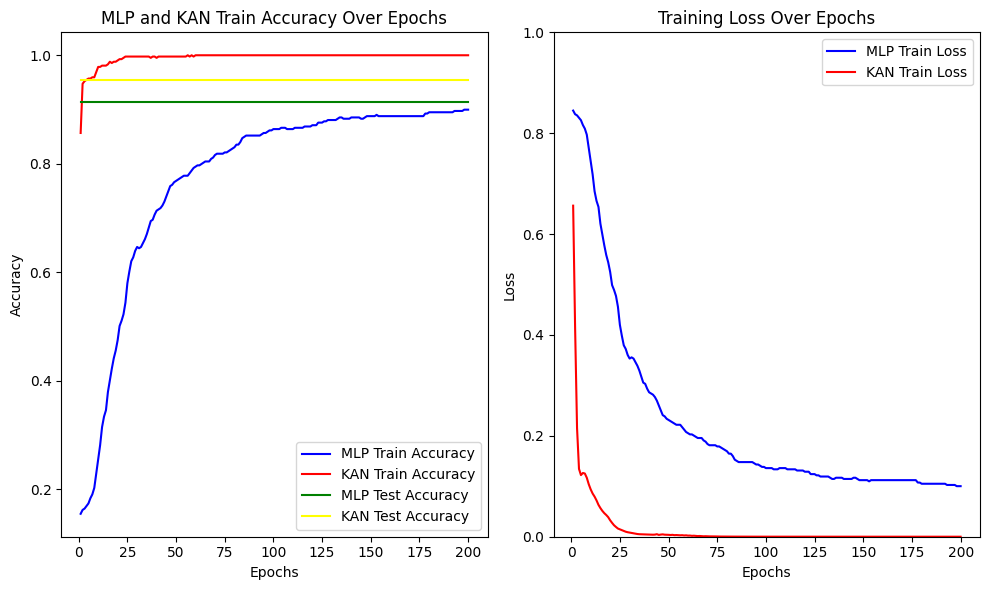

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       185
           1       0.96      0.97      0.96        95

    accuracy                           0.97       280
   macro avg       0.97      0.97      0.97       280
weighted avg       0.98      0.97      0.98       280

MLP Confusion Matrix:
[[181   4]
 [  3  92]]
KAN Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       185
           1       0.94      0.95      0.94        95

    accuracy                           0.96       280
   macro avg       0.96      0.96      0.96       280
weighted avg       0.96      0.96      0.96       280

KAN Confusion Matrix:
[[179   6]
 [  5  90]]


In [ ]:
mlp.coefs_ = [np.random.randn(*coef.shape) for coef in mlp.coefs_]
mlp.intercepts_ = [np.random.randn(*intercept.shape) for intercept in mlp.intercepts_]
mlp_1 = MLPClassifier(hidden_layer_sizes=(64, 32),
                    max_iter=1000,
                    activation='tanh',
                    learning_rate='adaptive',
                    alpha= 0.01,
                    solver='sgd',
                    random_state=42,
                    verbose = False)

kan_1= KAN(width=[9,19,2],
           grid=3,
           k=2,
           noise_scale=0.8,
           mult_arity=2,
           seed=42)

mlp_metrics_1,kan_metrics_1 = run_models(epochs)
plot_comparison_over_epochs(mlp_metrics_1, kan_metrics_1,epochs)
mlp_1.fit(x_train_tensor, y_train_tensor)
criteria_comparison(mlp_1,kan_1,x_test_tensor,y_test_tensor)

### Model Run with hidden layers
MLP: 3(64,32,16) and KAN: 1(5)

In [ ]:
# hyperparameter for the hidden layers
param_grid_mlp_2 = {'hidden_layer_sizes': [(64,32,16)],
    'activation': ['relu', 'tanh','logistics'],
    'alpha':[0.01,0.1],
    'solver':['adam','sgd'],
    'learning_rate':['adaptive','constant']}
mlp_2 = MLPClassifier(max_iter=1000, random_state=42)
clfmlp_2 = GridSearchCV(mlp_2, param_grid_mlp_2, cv=5, scoring='accuracy')
clfmlp_2.fit(X_train, y_train)
print(f"Best accuracy: {clfmlp_2.best_score_}")
print(f"Best parameters: {clfmlp_2.best_params_}")

Best accuracy: 0.9569994262765347
Best parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (64, 32, 16), 'learning_rate': 'adaptive', 'solver': 'sgd'}


In [ ]:
# kan hyperparameter tunning for kan_2
grids_2 = range(3,11,1)
ks_2 = range(2,9,1)
noises_2 = np.arange(0.1,0.9,0.1).tolist()
mult_arities_2 = [2,3,4,5]
accuracies_2=[]
hyperparameters_2 = []
for grid in grids_2:
  for k in ks_2:
    for noise in noises_2:
      for mult_arity in mult_arities_2:
        kan = KAN(width=[9,5,2], grid=grid, k=k,noise_scale=noise,mult_arity=mult_arity,seed=42)
        y_pred = kan(x_train_tensor).argmax(1)
        accuracy = accuracy_score(y_train_tensor, y_pred)
        accuracies_2.append(accuracy)
        hyperparameters_2.append((grid,k,noise,mult_arity))
print(max(accuracies_2))
index = accuracies_2.index(max(accuracies_2))
print(hyperparameters_2[index])

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model vers

checkpoint directory created: ./model
saving model version 0.0
Epoch [10/200],MLP Train Loss: 0.745, MLP Train Accuracy: 0.2553699284009546
Epoch [20/200],MLP Train Loss: 0.523, MLP Train Accuracy: 0.477326968973747
Epoch [30/200],MLP Train Loss: 0.353, MLP Train Accuracy: 0.6467780429594272
Epoch [40/200],MLP Train Loss: 0.286, MLP Train Accuracy: 0.7136038186157518
Epoch [50/200],MLP Train Loss: 0.232, MLP Train Accuracy: 0.7684964200477327
Epoch [60/200],MLP Train Loss: 0.205, MLP Train Accuracy: 0.7947494033412887
Epoch [70/200],MLP Train Loss: 0.184, MLP Train Accuracy: 0.8162291169451074
Epoch [80/200],MLP Train Loss: 0.169, MLP Train Accuracy: 0.8305489260143198
Epoch [90/200],MLP Train Loss: 0.148, MLP Train Accuracy: 0.8520286396181385
Epoch [100/200],MLP Train Loss: 0.136, MLP Train Accuracy: 0.863961813842482
Epoch [110/200],MLP Train Loss: 0.136, MLP Train Accuracy: 0.863961813842482
Epoch [120/200],MLP Train Loss: 0.129, MLP Train Accuracy: 0.8711217183770883
Epoch [130/20

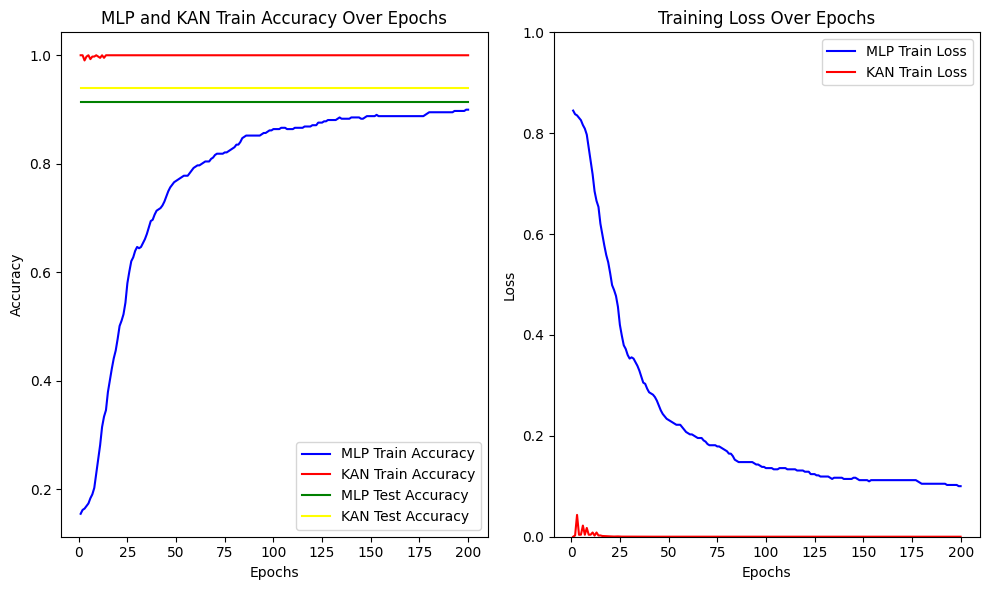

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       185
           1       0.96      0.98      0.97        95

    accuracy                           0.98       280
   macro avg       0.97      0.98      0.98       280
weighted avg       0.98      0.98      0.98       280

MLP Confusion Matrix:
[[181   4]
 [  2  93]]
KAN Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       185
           1       0.88      0.81      0.84        95

    accuracy                           0.90       280
   macro avg       0.89      0.88      0.88       280
weighted avg       0.90      0.90      0.90       280

KAN Confusion Matrix:
[[174  11]
 [ 18  77]]


In [ ]:
mlp.coefs_ = [np.random.randn(*coef.shape) for coef in mlp.coefs_]
mlp.intercepts_ = [np.random.randn(*intercept.shape) for intercept in mlp.intercepts_]
mlp_2 = MLPClassifier(hidden_layer_sizes=(64, 32, 16),
                    max_iter=1000,
                    activation='tanh',
                    learning_rate='adaptive',
                    alpha= 0.01,
                    solver='sgd',
                    random_state=42,
                    verbose = False)

kan_2= KAN(width=[9,5,2],
           grid=10,
           k=5,
           noise_scale=0.4,
           mult_arity=2,
           seed=42)

mlp_metrics_2,kan_metrics_2 = run_models(epochs)
plot_comparison_over_epochs(mlp_metrics_2, kan_metrics_2,epochs)
mlp_2.fit(x_train_tensor, y_train_tensor)
criteria_comparison(mlp_2,kan_2,x_test_tensor,y_test_tensor)